In [1]:
import pandas as pd
import numpy as np
import copy
import functools
import itertools
import numpy as np
from itertools import product
from functools import partial
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import warnings

warnings.filterwarnings('ignore')

In [46]:
import pandas as pd
import numpy as np
import copy
import scipy
from math import exp
import functools
import itertools
import numpy as np
from itertools import product
from functools import partial
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.signal import fftconvolve
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import BaseForest
from sklearn.ensemble._bagging import BaseBagging
from sklearn.ensemble._forest import _generate_sample_indices, _get_n_samples_bootstrap

def gfit(X, sigma, p=5, nbin=200, unif_fraction=0.1):
    """
    Fit empirical Bayes prior in the hierarchical model [Efron2014]_.

    .. math::

        mu ~ G, X ~ N(mu, sigma^2)

    Parameters
    ----------
    X: ndarray
        A 1D array of observations.
    sigma: float
        Noise estimate on X.
    p: int
        Number of parameters used to fit G. Default: 5
    nbin: int
        Number of bins used for discrete approximation.
        Default: 200
    unif_fraction: float
        Fraction of G modeled as "slab". Default: 0.1

    Returns
    -------
    An array of the posterior density estimate g.
    """
    min_x = min(min(X) - 2 * np.std(X, ddof=1), 0)
    max_x = max(max(X) + 2 * np.std(X, ddof=1),
                np.std(X, ddof=1))
    xvals = np.linspace(min_x, max_x, nbin)
    binw = (max_x - min_x) / (nbin - 1)

    zero_idx = max(np.where(xvals <= 0)[0])
    noise_kernel = norm().pdf(xvals / sigma) * binw / sigma

    if zero_idx > 0:
        noise_rotate = noise_kernel[list(np.arange(zero_idx, len(xvals))) +
                                    list(np.arange(0, zero_idx))]
    else:
        noise_rotate = noise_kernel

    XX = np.zeros((p, len(xvals)), dtype=np.float)
    for ind, exp in enumerate(range(1, p+1)):
        mask = np.ones_like(xvals)
        mask[np.where(xvals <= 0)[0]] = 0
        XX[ind, :] = pow(xvals, exp) * mask
    XX = XX.T

    def neg_loglik(eta):
        mask = np.ones_like(xvals)
        mask[np.where(xvals <= 0)[0]] = 0
        g_eta_raw = np.exp(np.dot(XX, eta)) * mask
        if ((np.sum(g_eta_raw) == np.inf) |
            (np.sum(g_eta_raw) <=
                100 * np.finfo(np.double).tiny)):
                return (1000 * (len(X) + sum(eta ** 2)))

        g_eta_main = g_eta_raw / sum(g_eta_raw)
        g_eta = ((1 - unif_fraction) * g_eta_main +
                 unif_fraction * mask / sum(mask))
        f_eta = fftconvolve(g_eta, noise_rotate, mode='same')
        return np.sum(np.interp(X, xvals,
                      -np.log(np.maximum(f_eta, 0.0000001))))

    eta_hat = minimize(neg_loglik,
                       list(itertools.repeat(-1, p))).x
    g_eta_raw = np.exp(np.dot(XX, eta_hat)) * mask
    g_eta_main = g_eta_raw / sum(g_eta_raw)
    g_eta = ((1 - unif_fraction) * g_eta_main +
             unif_fraction * mask) / sum(mask)

    return xvals, g_eta


def gbayes(x0, g_est, sigma):
    """
    Estimate Bayes posterior with Gaussian noise [Efron2014]_.

    Parameters
    ----------
    x0: ndarray
        an observation
    g_est: float
        a prior density, as returned by gfit
    sigma: int
        noise estimate

    Returns
    -------
    An array of the posterior estimate E[mu | x0]
    """

    Kx = norm().pdf((g_est[0] - x0) / sigma)
    post = Kx * g_est[1]
    post /= sum(post)
    return sum(post * g_est[0])


def calibrateEB(variances, sigma2):
    """
    Calibrate noisy variance estimates with empirical Bayes.

    Parameters
    ----------
    vars: ndarray
        List of variance estimates.
    sigma2: int
        Estimate of the Monte Carlo noise in vars.

    Returns
    -------
    An array of the calibrated variance estimates
    """
    if (sigma2 <= 0 or min(variances) == max(variances)):
        return(np.maximum(variances, 0))
    sigma = np.sqrt(sigma2)
    eb_prior = gfit(variances, sigma)
    # Set up a partial execution of the function
    part = functools.partial(gbayes, g_est=eb_prior,
                             sigma=sigma)
    if len(variances) >= 200:
        # Interpolate to speed up computations:
        calib_x = np.percentile(variances,
                                np.arange(0, 102, 2))
        calib_y = list(map(part, calib_x))
        calib_all = np.interp(variances, calib_x, calib_y)
    else:
        calib_all = list(map(part, variances))

    return np.asarray(calib_all)

def compute_V(forest, X_train, X_test, calibrate=True):
    def _infer_inbag(n_samples, forest):
        n_trees = forest.n_estimators
        inbag = np.zeros((n_samples, n_trees))
        sample_idx = []
        if isinstance(forest, BaseForest):
            n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, forest.max_samples)

            for t_idx in range(n_trees):
                sample_idx.append(
                    _generate_sample_indices(
                        forest.estimators_[t_idx].random_state,
                        n_samples,
                        n_samples_bootstrap,
                    )
                )
                inbag[:, t_idx] = np.bincount(sample_idx[-1], minlength=n_samples)
        elif isinstance(forest, BaseBagging):
            for t_idx, estimator_sample in enumerate(forest.estimators_samples_):
                sample_idx.append(estimator_sample)
                inbag[:, t_idx] = np.bincount(sample_idx[-1], minlength=n_samples)

        return inbag 

    def _core_computation_IJ(inbag, pred_centered, n_trees):
        return np.sum((np.dot(inbag - 1, pred_centered.T) / n_trees) ** 2, 0) 
    
    def _core_computation_J(inbag, pred, bagging_mean, n_samples):
        noinbag = np.where(inbag>0, 0, 1)
        delta_sum = np.dot(noinbag, pred.T)
        theta_ = delta_sum/np.sum(noinbag, 1).reshape((-1, 1))
        return (n_samples - 1)* np.mean((theta_ - bagging_mean.T)**2, 0)

    def _bias_correction_IJ(V_IJ, inbag, pred_centered, n_trees):
        n_train_samples = inbag.shape[0]
        n_var = np.mean(
            np.square(inbag[0:n_trees]).mean(axis=1).T.view()
            - np.square(inbag[0:n_trees].mean(axis=1)).T.view()
        )
        boot_var = np.square(pred_centered).sum(axis=1) / n_trees
        bias_correction = n_train_samples * n_var * boot_var / n_trees
        V_IJ_unbiased = V_IJ - bias_correction
        return V_IJ_unbiased 
    
    def _bias_correction_J(V_J, inbag, pred_centered, n_trees):
        n_train_samples = inbag.shape[0]
        n_var = np.mean(
            np.square(inbag[0:n_trees]).mean(axis=1).T.view()
            - np.square(inbag[0:n_trees].mean(axis=1)).T.view()
        )
        boot_var = np.square(pred_centered).sum(axis=1) / n_trees
        bias_correction = (exp(1) - 1) * n_train_samples * n_var * boot_var / n_trees
        V_J_unbiased = V_J - bias_correction
        return V_J_unbiased 

    inbag = _infer_inbag(X_train.shape[0], forest) 
    pred = np.array([tree.predict(X_test) for tree in forest]).T
    pred_mean = np.mean(pred, 0)
    bagging_mean = np.mean(pred, 1)
    pred_centered = pred - pred_mean
    n_trees = forest.n_estimators
    V_J = _core_computation_J(inbag, pred, bagging_mean, X_train.shape[0])
    V_J_unbiased = _bias_correction_J(V_J, inbag, pred_centered, n_trees)
    V_IJ = _core_computation_IJ(inbag, pred_centered, n_trees)
    V_IJ_unbiased = _bias_correction_IJ(V_IJ, inbag, pred_centered, n_trees)
    # calibration
    if calibrate:
        calibration_ratio = 2
        n_sample = np.ceil(n_trees / calibration_ratio)
        new_forest = copy.deepcopy(forest)
        random_idx = np.random.permutation(len(new_forest.estimators_))[: int(n_sample)]
        new_forest.estimators_ = list(np.array(new_forest.estimators_)[random_idx])
        if hasattr(new_forest, "_seeds"):
            new_forest._seeds = new_forest._seeds[random_idx]

        new_forest.n_estimators = int(n_sample)
        _, results_ss_J_, _,results_ss_IJ = compute_V(
            new_forest,
            X_train,
            X_test,
            calibrate=False
        )
        # Use this second set of variance estimates
        # to estimate scale of Monte Carlo noise
        sigma2_ss_J = np.mean((results_ss_J_ - V_J_unbiased) ** 2)
        sigma2_ss_IJ = np.mean((results_ss_IJ - V_IJ_unbiased) ** 2)
        delta = n_sample / n_trees
        sigma2_J = (delta ** 2 + (1 - delta) ** 2) / (2 * (1 - delta) ** 2) * sigma2_ss_J
        sigma2_IJ = (delta ** 2 + (1 - delta) ** 2) / (2 * (1 - delta) ** 2) * sigma2_ss_IJ

        # Use Monte Carlo noise scale estimate for empirical Bayes calibration
        V_J_calibrated = calibrateEB(V_J, sigma2_J)
        V_J_U_calibrated = calibrateEB(V_J_unbiased, sigma2_J)
        V_IJ_calibrated = calibrateEB(V_IJ, sigma2_IJ)
        V_IJ_U_calibrated = calibrateEB(V_IJ_unbiased, sigma2_IJ)
        return V_J, V_J_unbiased, V_IJ_unbiased, V_IJ_U_calibrated
    return V_J, V_J_unbiased, V_IJ, V_IJ_unbiased

### Figure 2

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [30]:
n = 500
B = 500
eps_var = 2**2
X = np.linspace(0, 1, num=n, endpoint=True).reshape((-1, 1))
def simulation_figure_2(random_seed):
    np.random.seed(random_seed)
    y = np.zeros(shape=(n,1))
    y[(X>=0.35) & (X<=0.65)] = 0.7
    y[(X>=0.45) & (X<=0.55)] = 1.4
    y = (y+ np.random.normal(0, eps_var, size = (n, 1))).ravel()                                                      
    bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes = 5), n_estimators=B, random_state=random_seed)
    bagging.fit(X, y)
    _, _, V_IJ_U, V_IJ_C = compute_V(bagging, X, X)
    return V_IJ_U, V_IJ_C

In [31]:
%%time
n_process = 100
n_parallel = 100
random_seeds = list(range(n_parallel))
with Pool(processes = n_process) as pool:
    collection_source = pool.map(simulation_figure_2, random_seeds)

collection_source = np.array(collection_source)

CPU times: user 187 ms, sys: 808 ms, total: 996 ms
Wall time: 14.8 s


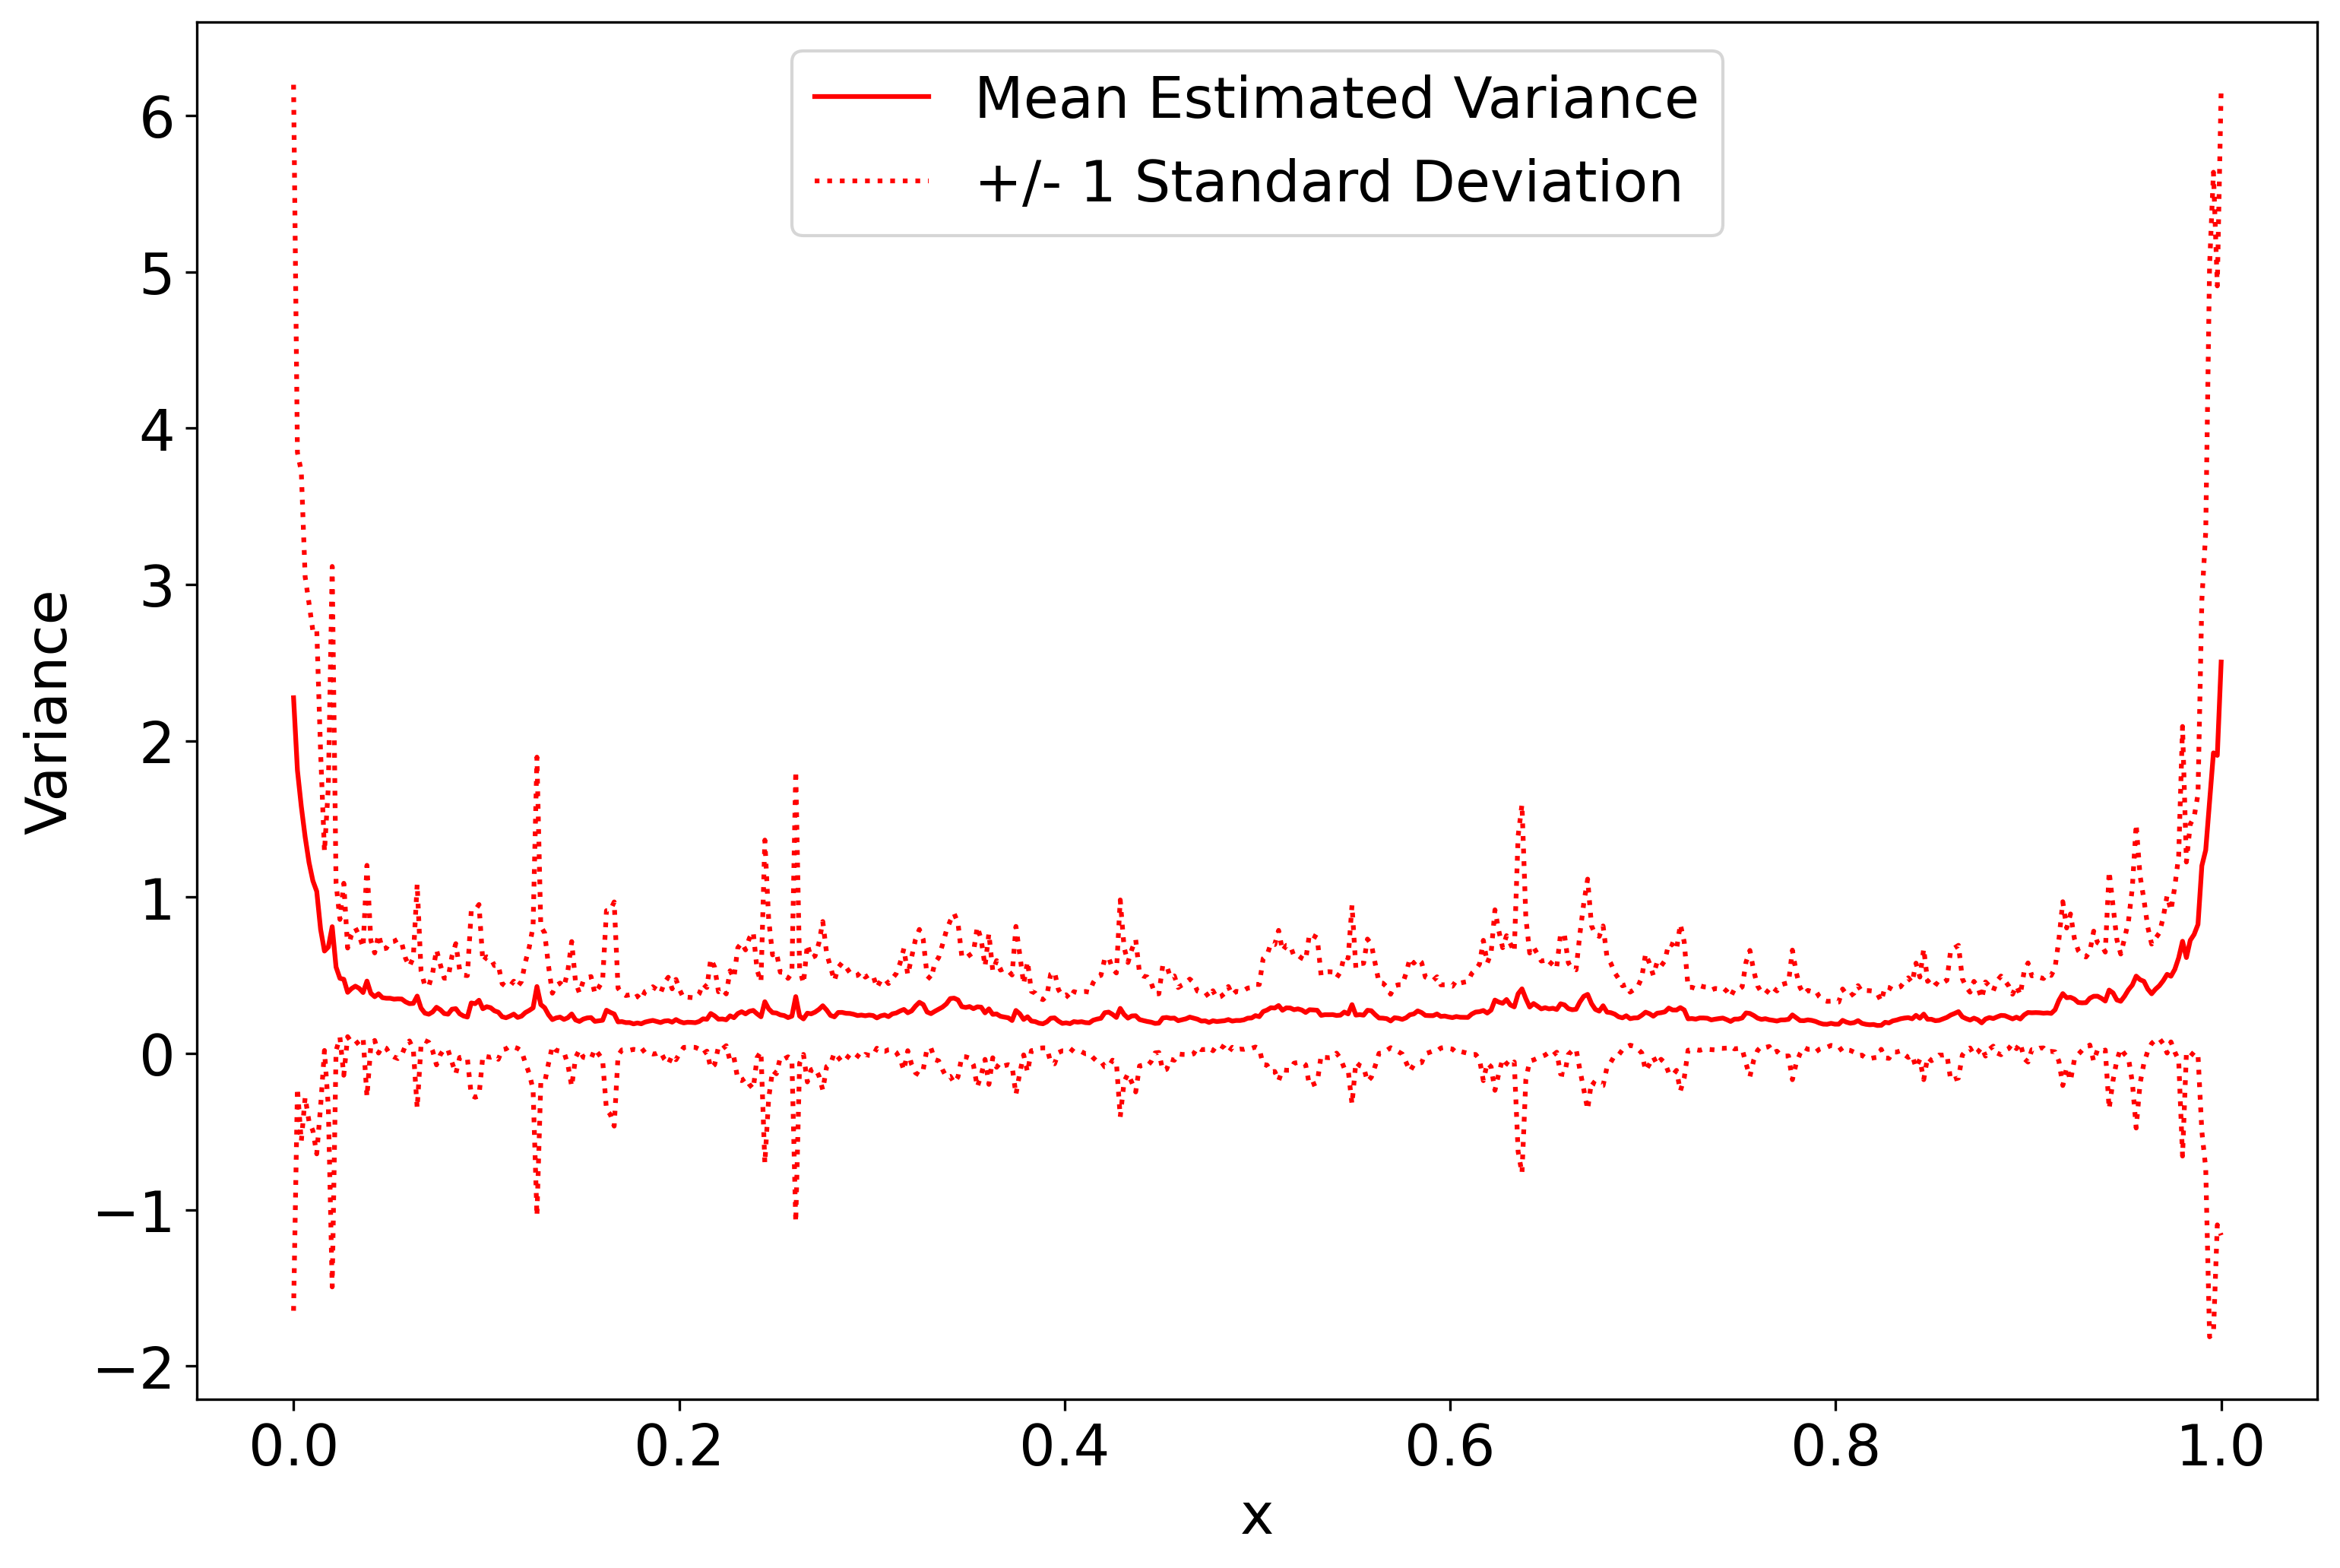

In [32]:
fig, ax = plt.subplots(figsize = (12, 8), dpi = 300)
X = np.linspace(0, 1, num=n, endpoint=True).reshape((-1, 1))
mean = collection_source[:, 0, :].mean(axis = 0)
std = collection_source[:, 0, :].std(axis = 0)
ax.plot(X.ravel(), mean.ravel(), 'r-', label = 'Mean Estimated Variance')
ax.plot(X.ravel(), mean.ravel() + std.ravel(), 'r:', label = '+/- 1 Standard Deviation')
ax.plot(X.ravel(), mean.ravel() - std.ravel(), 'r:')
plt.xlabel('x')
plt.ylabel('Variance') 
plt.legend()
plt.savefig('../figures/Before_Calibration_5.pdf', dpi = 300)
plt.show()

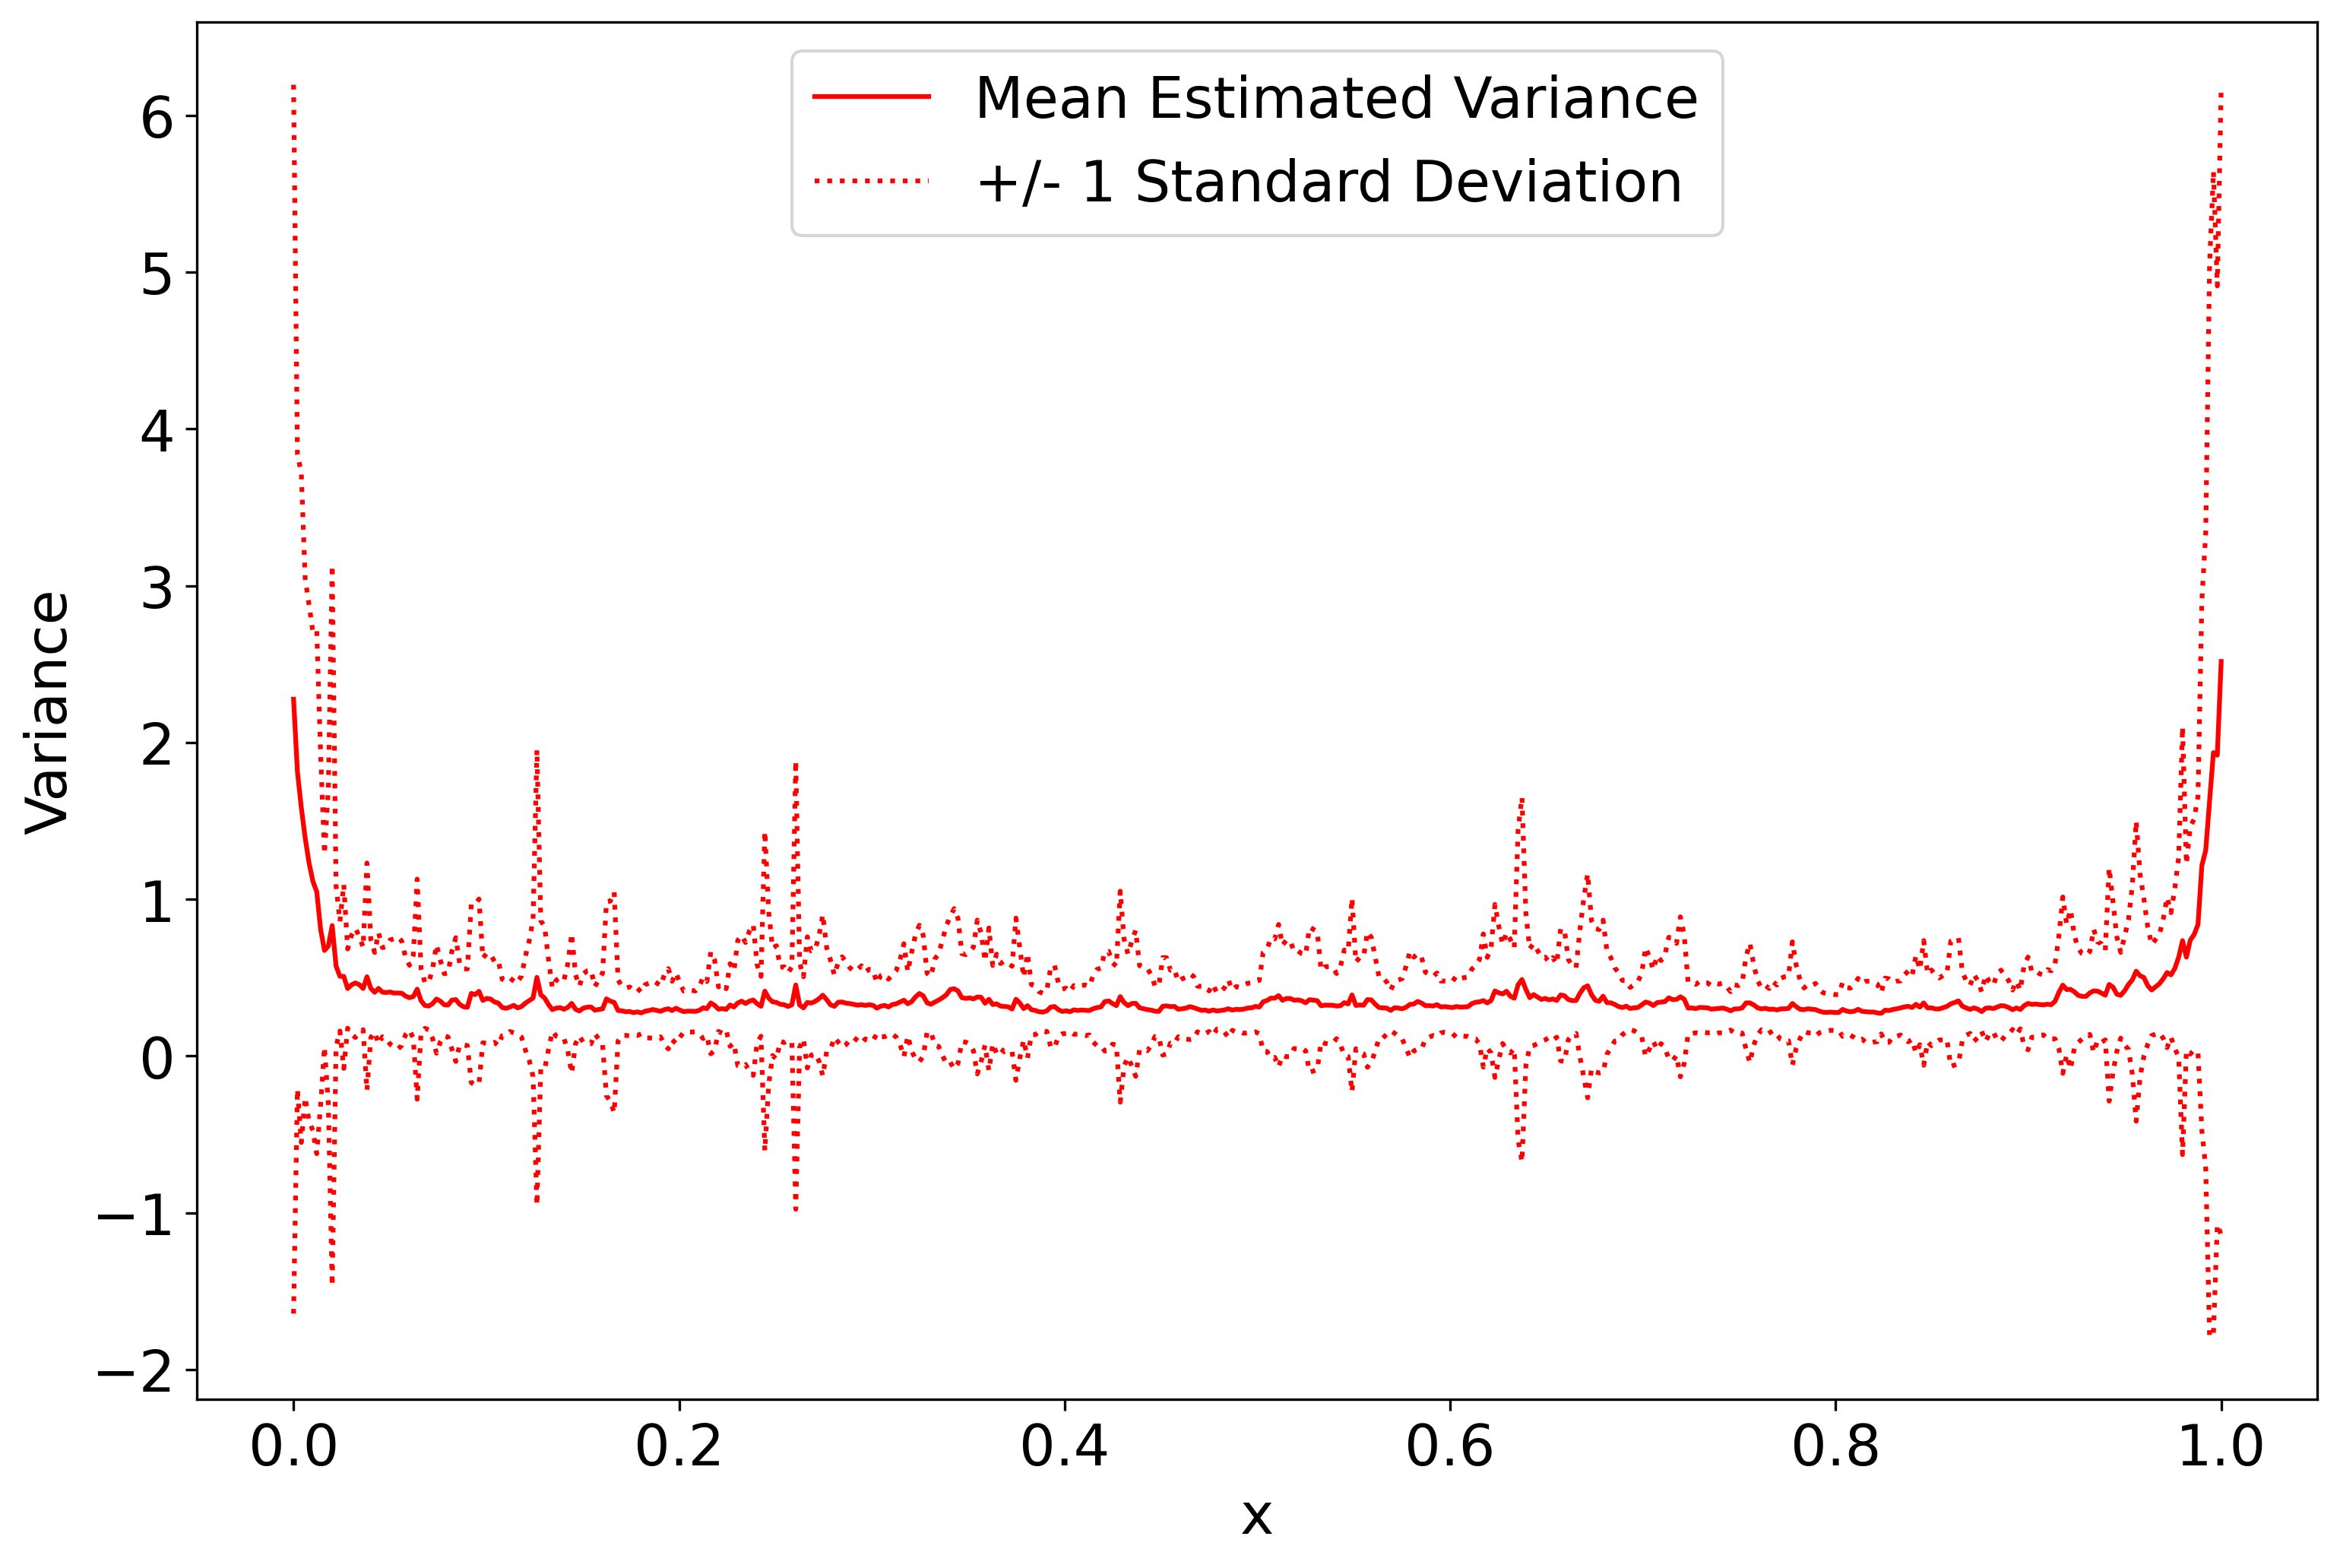

In [34]:
fig, ax = plt.subplots(figsize = (12, 8), dpi = 300)
X = np.linspace(0, 1, num=n, endpoint=True).reshape((-1, 1))
mean = collection_source[:, 1, :].mean(axis = 0)
std = collection_source[:, 1, :].std(axis = 0)
ax.plot(X.ravel(), mean.ravel(), 'r-', label = 'Mean Estimated Variance')
ax.plot(X.ravel(), mean.ravel() + std.ravel(), 'r:', label = '+/- 1 Standard Deviation')
ax.plot(X.ravel(), mean.ravel() - std.ravel(), 'r:')
plt.xlabel('x')
plt.ylabel('Variance') 
plt.legend()
plt.savefig('../figures/Calibration_5.pdf', dpi = 300)
plt.show()

### Figure 4

In [36]:
df = pd.read_table('../data/spambase.data', sep = ',', header = None).values
X = df[:, :-1]
y = df[:, -1]
n = df.shape[0]
train_size = 3065
test_size = n - train_size

In [43]:
def figure_4(max_features, random_seed):
    np.random.seed(random_seed)
    train_indice = np.random.choice(range(n), 3065, replace = False)
    test_indice = np.array(list(set(np.arange(n)) - set(train_indice)))
    X_train, y_train, X_test, y_test = X[train_indice], y[train_indice], X[test_indice], y[test_indice]

    # create RandomForestClassifier
    n_trees = 4000
    spam_RFC = RandomForestClassifier(max_features=max_features, n_estimators=n_trees,
                                      random_state=random_seed)
    spam_RFC.fit(X_train, y_train)
    test_prob = spam_RFC.predict_proba(X_test)[:, 1]
    correct_indice = (spam_RFC.predict(X_test)==y_test)
    error_indice = (spam_RFC.predict(X_test)!=y_test)
    _, _, V_IJ, V_IJ_C = compute_V(spam_RFC, X_train, X_test)
    return (test_prob[correct_indice], test_prob[error_indice], V_IJ[correct_indice], 
            V_IJ[error_indice], V_IJ_C[correct_indice], V_IJ_C[error_indice])

In [44]:
%%time
n_process = 10
n_parallel = 10
random_seeds = list(range(n_parallel))
max_features = [5, 19, 57]
with Pool(processes = n_process) as pool:
    collection_source = pool.starmap(figure_4, product(max_features, random_seeds))

collection = list()
for i in range(len(max_features)):
    collection.append(list())
    for j in range(n_parallel):
        collection[i].append(collection_source[i*len(max_features)+j])

CPU times: user 252 ms, sys: 182 ms, total: 433 ms
Wall time: 4min 9s


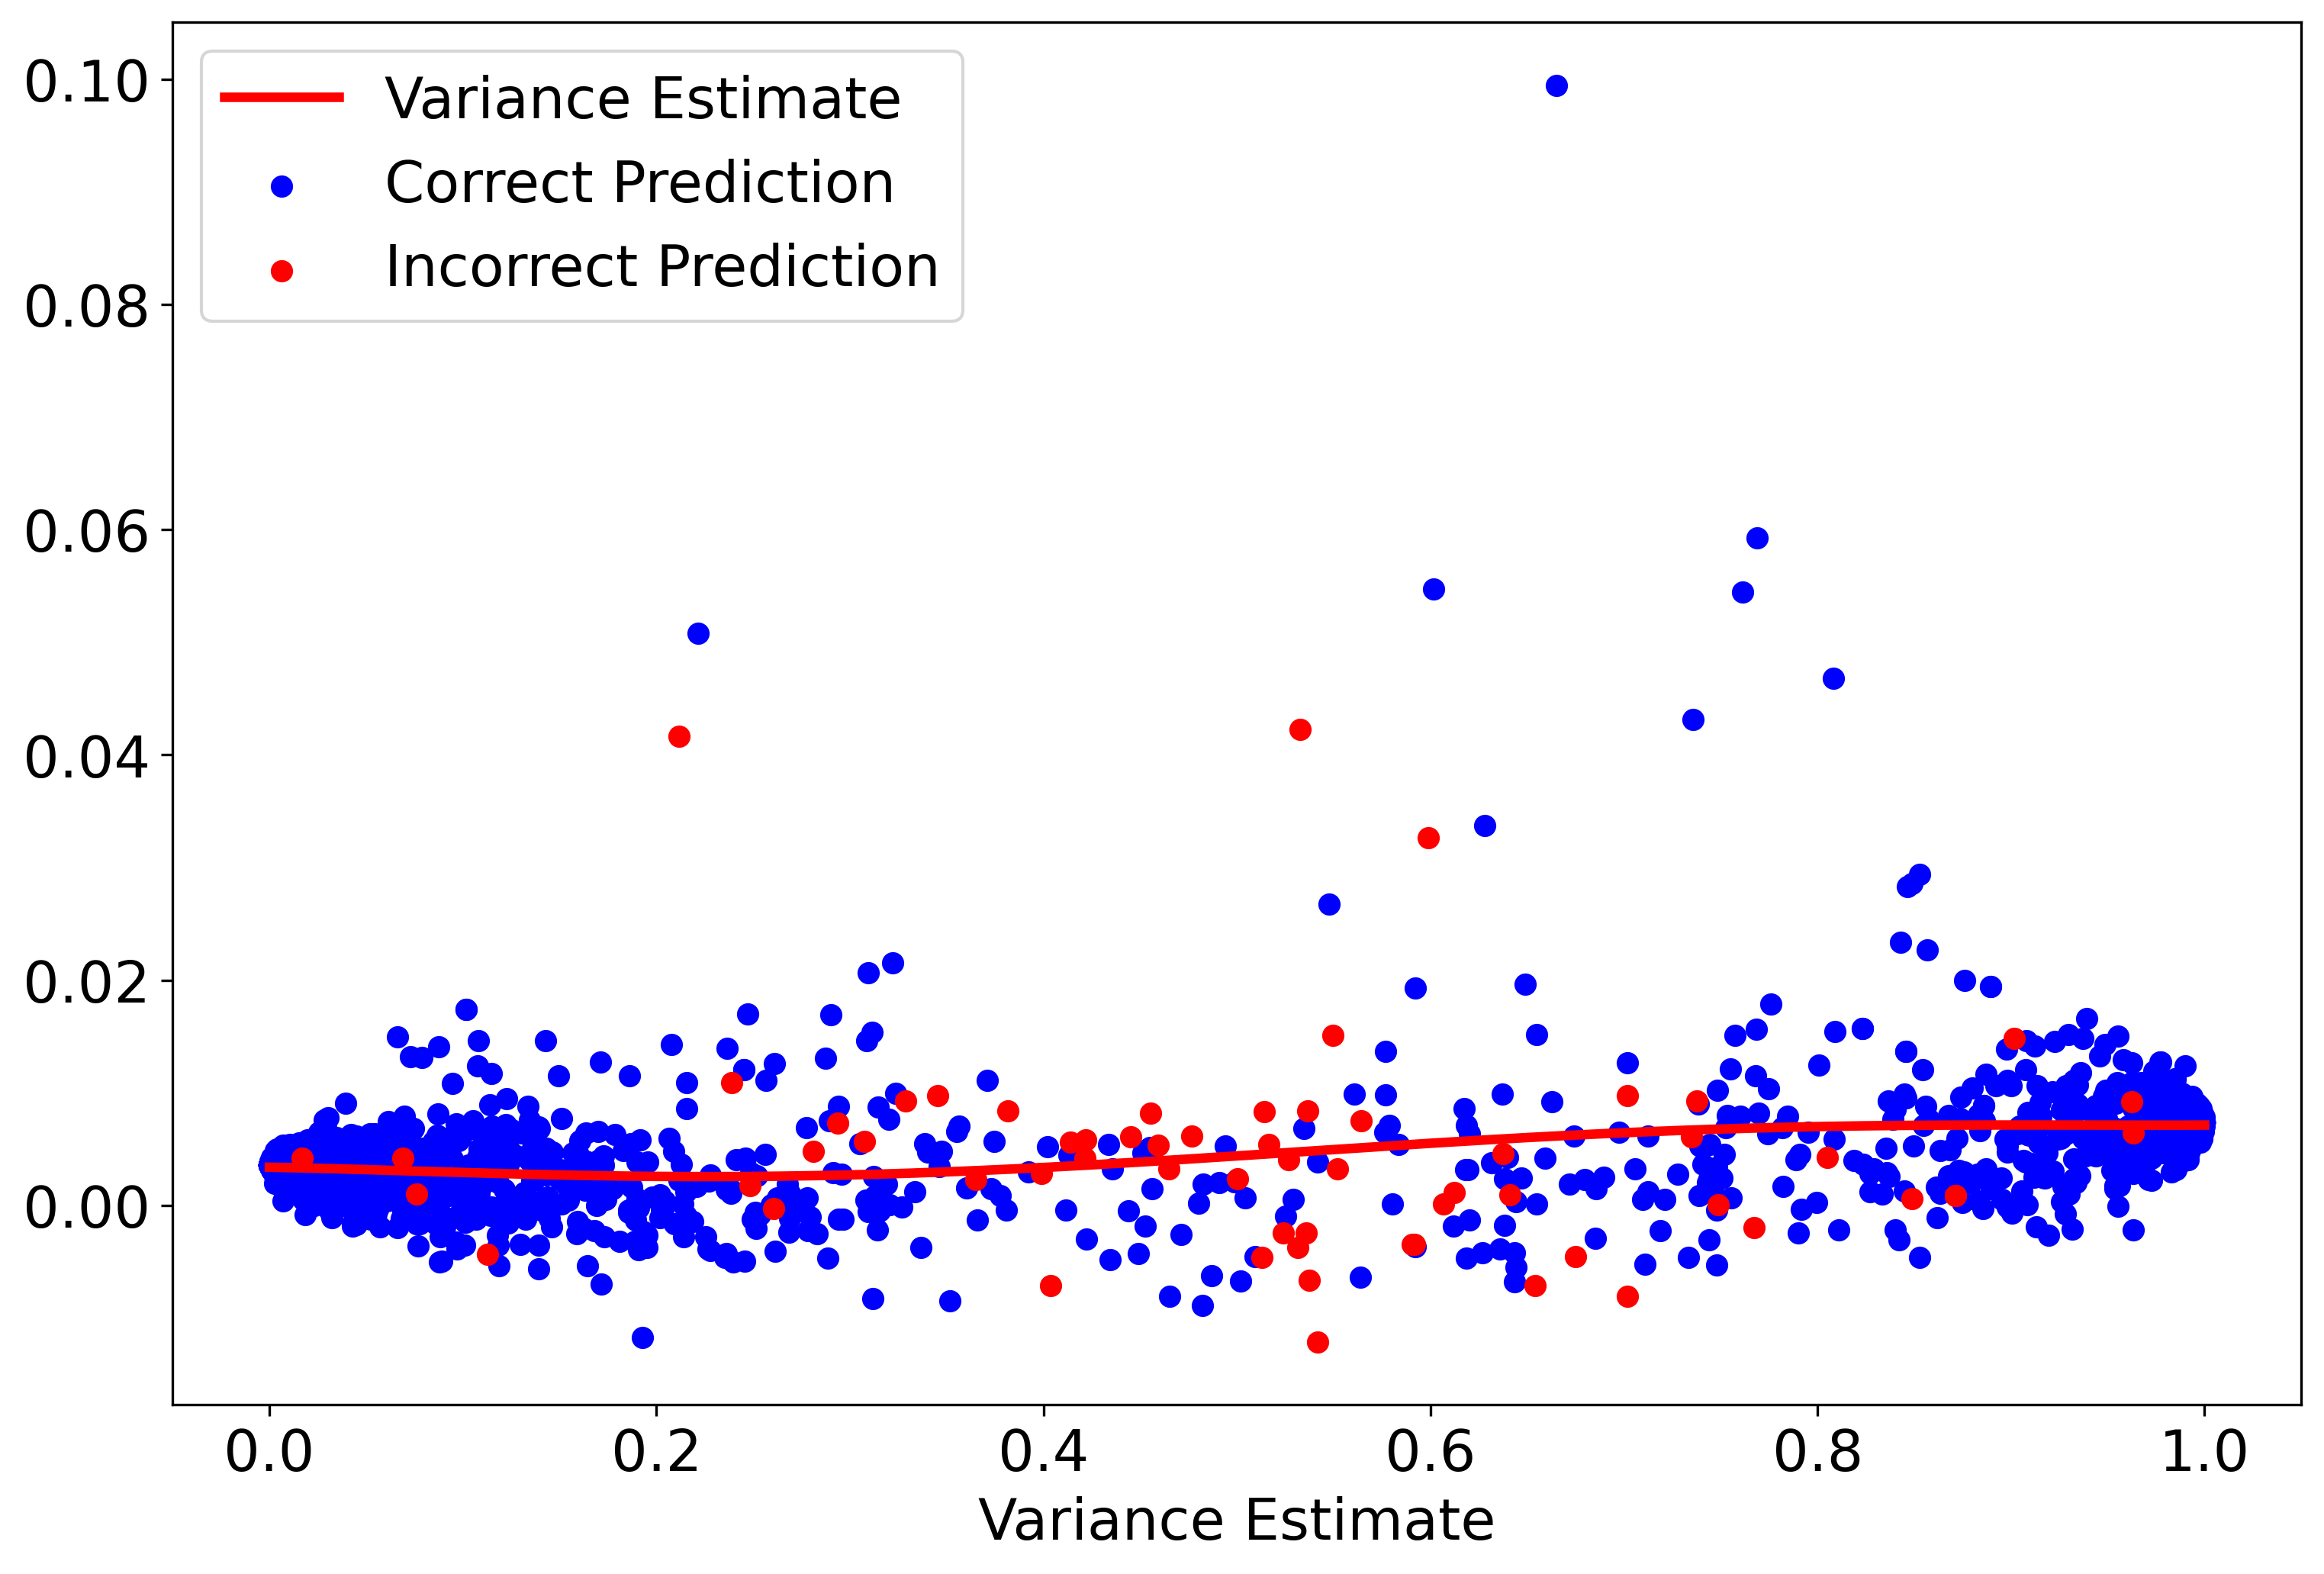

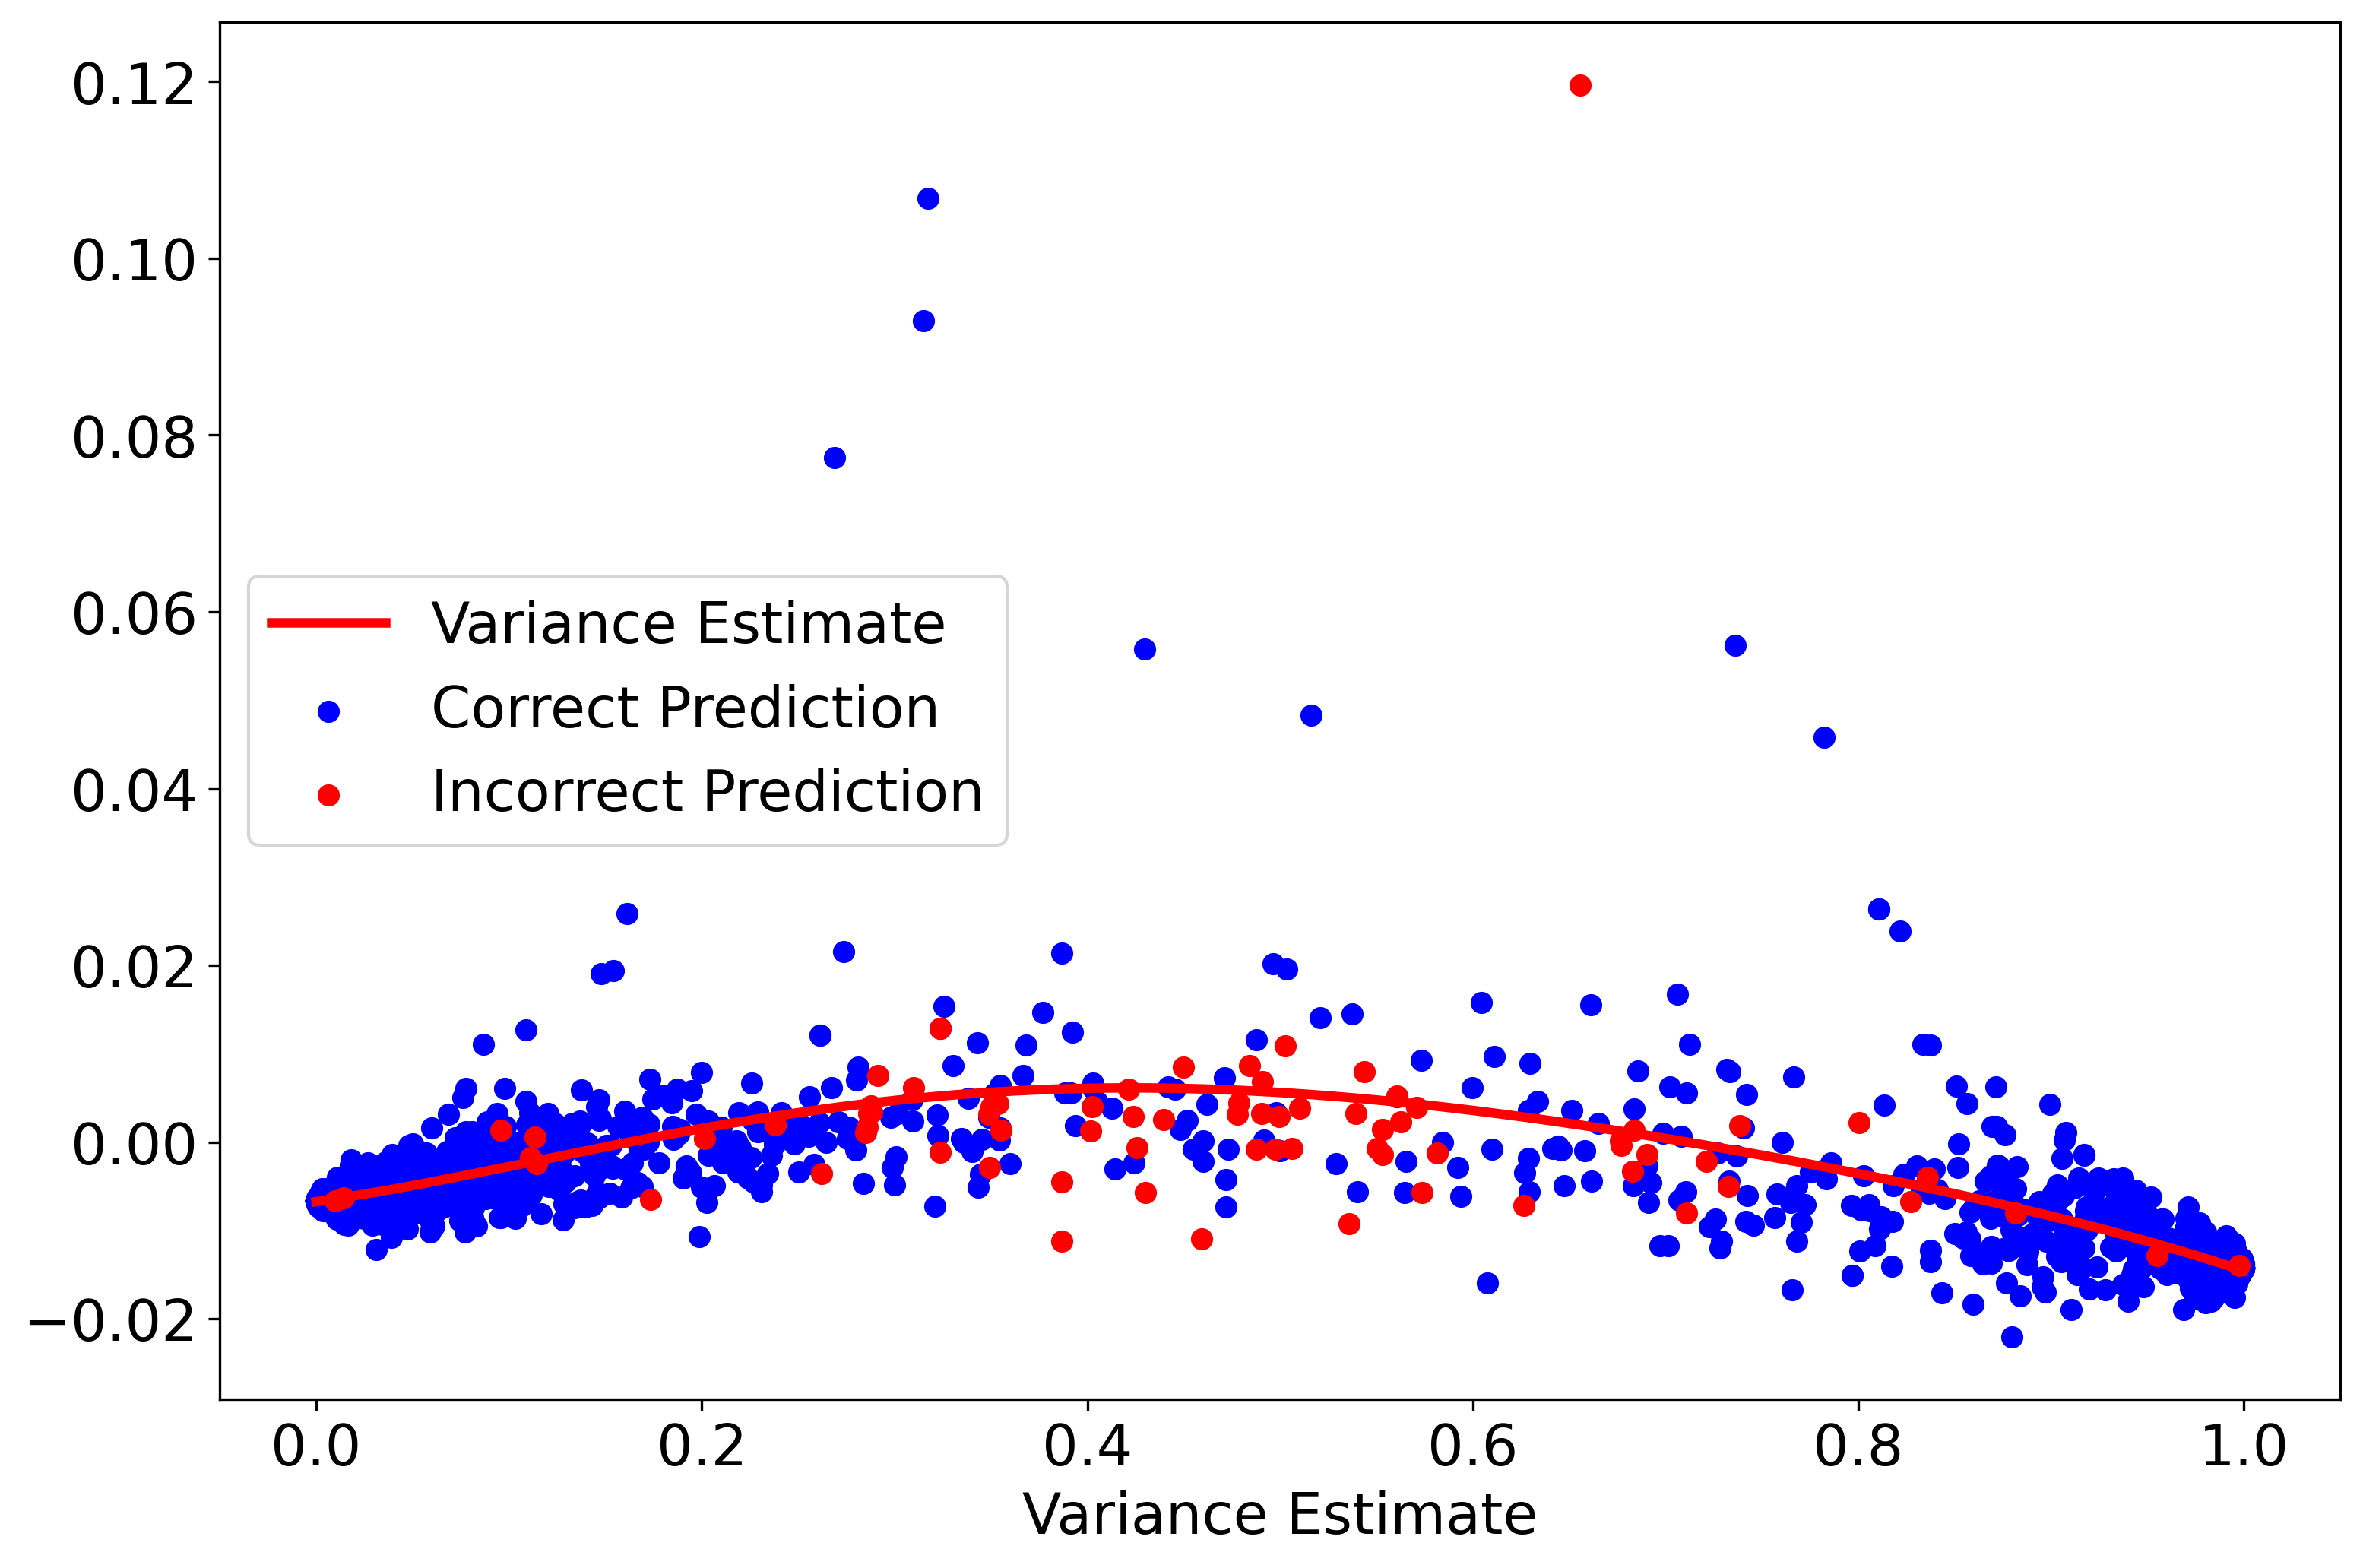

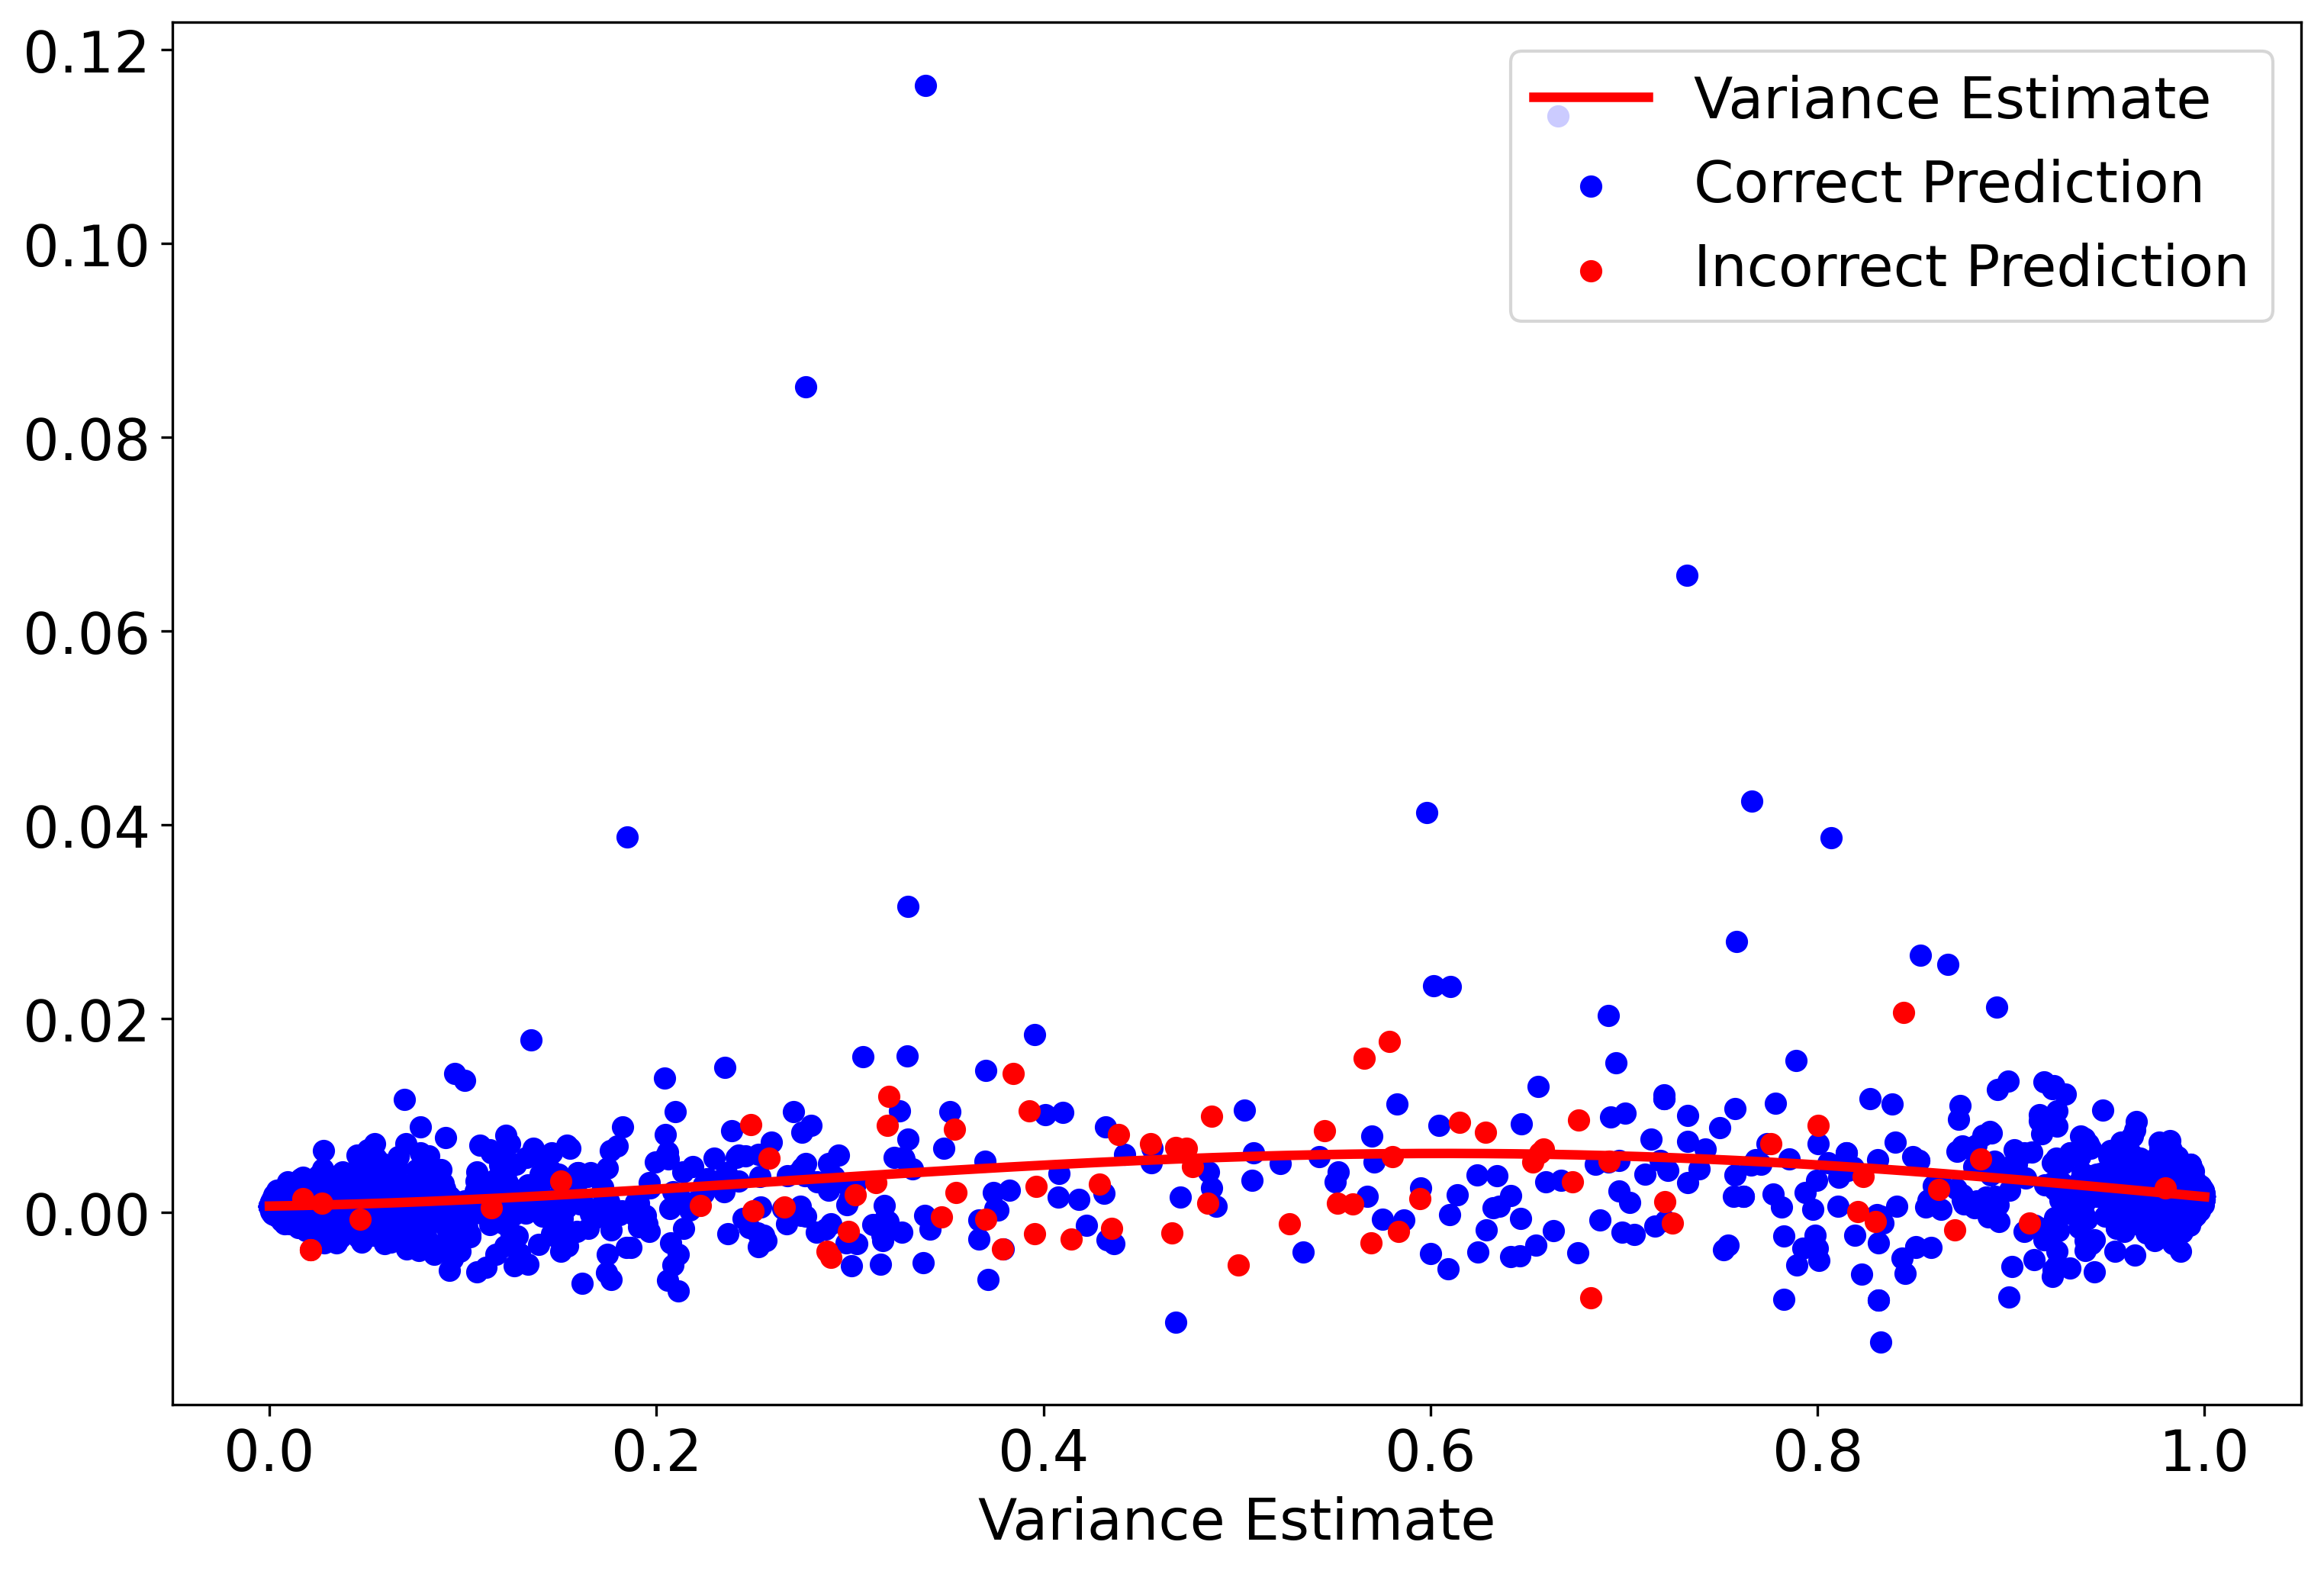

In [47]:
for i, max_feature in enumerate(max_features): 
    fig, axes = plt.subplots(figsize = (12, 8), nrows=1, ncols=1, dpi = 300)
    test_prob_correct, test_prob_error, V_IJ_correct, V_IJ_error, V_IJC_correct, V_IJC_error = collection[i][0]
    axes.scatter(test_prob_correct, V_IJ_correct, color = 'b', label = 'Correct Prediction')
    axes.scatter(test_prob_error, V_IJ_error, color = 'r', label = 'Incorrect Prediction')
    indice = np.argsort(np.concatenate([test_prob_correct, test_prob_error]))
    test_prob = np.concatenate([test_prob_correct, test_prob_error])[indice]
    V_IJ = np.concatenate([V_IJ_correct, V_IJ_error])[indice]
    spl = scipy.interpolate.UnivariateSpline(test_prob, V_IJ, k =5)
    xs = np.linspace(0, 1, 1000)
    axes.plot(xs, spl(xs), color = 'red', linewidth = 3, label = 'Variance Estimate')
    plt.xlabel('Prediction')
    plt.xlabel('Variance Estimate')
    plt.legend()
    plt.savefig('../figures/BC_Real' + str(i) + '.pdf', dpi = 300)
plt.show()

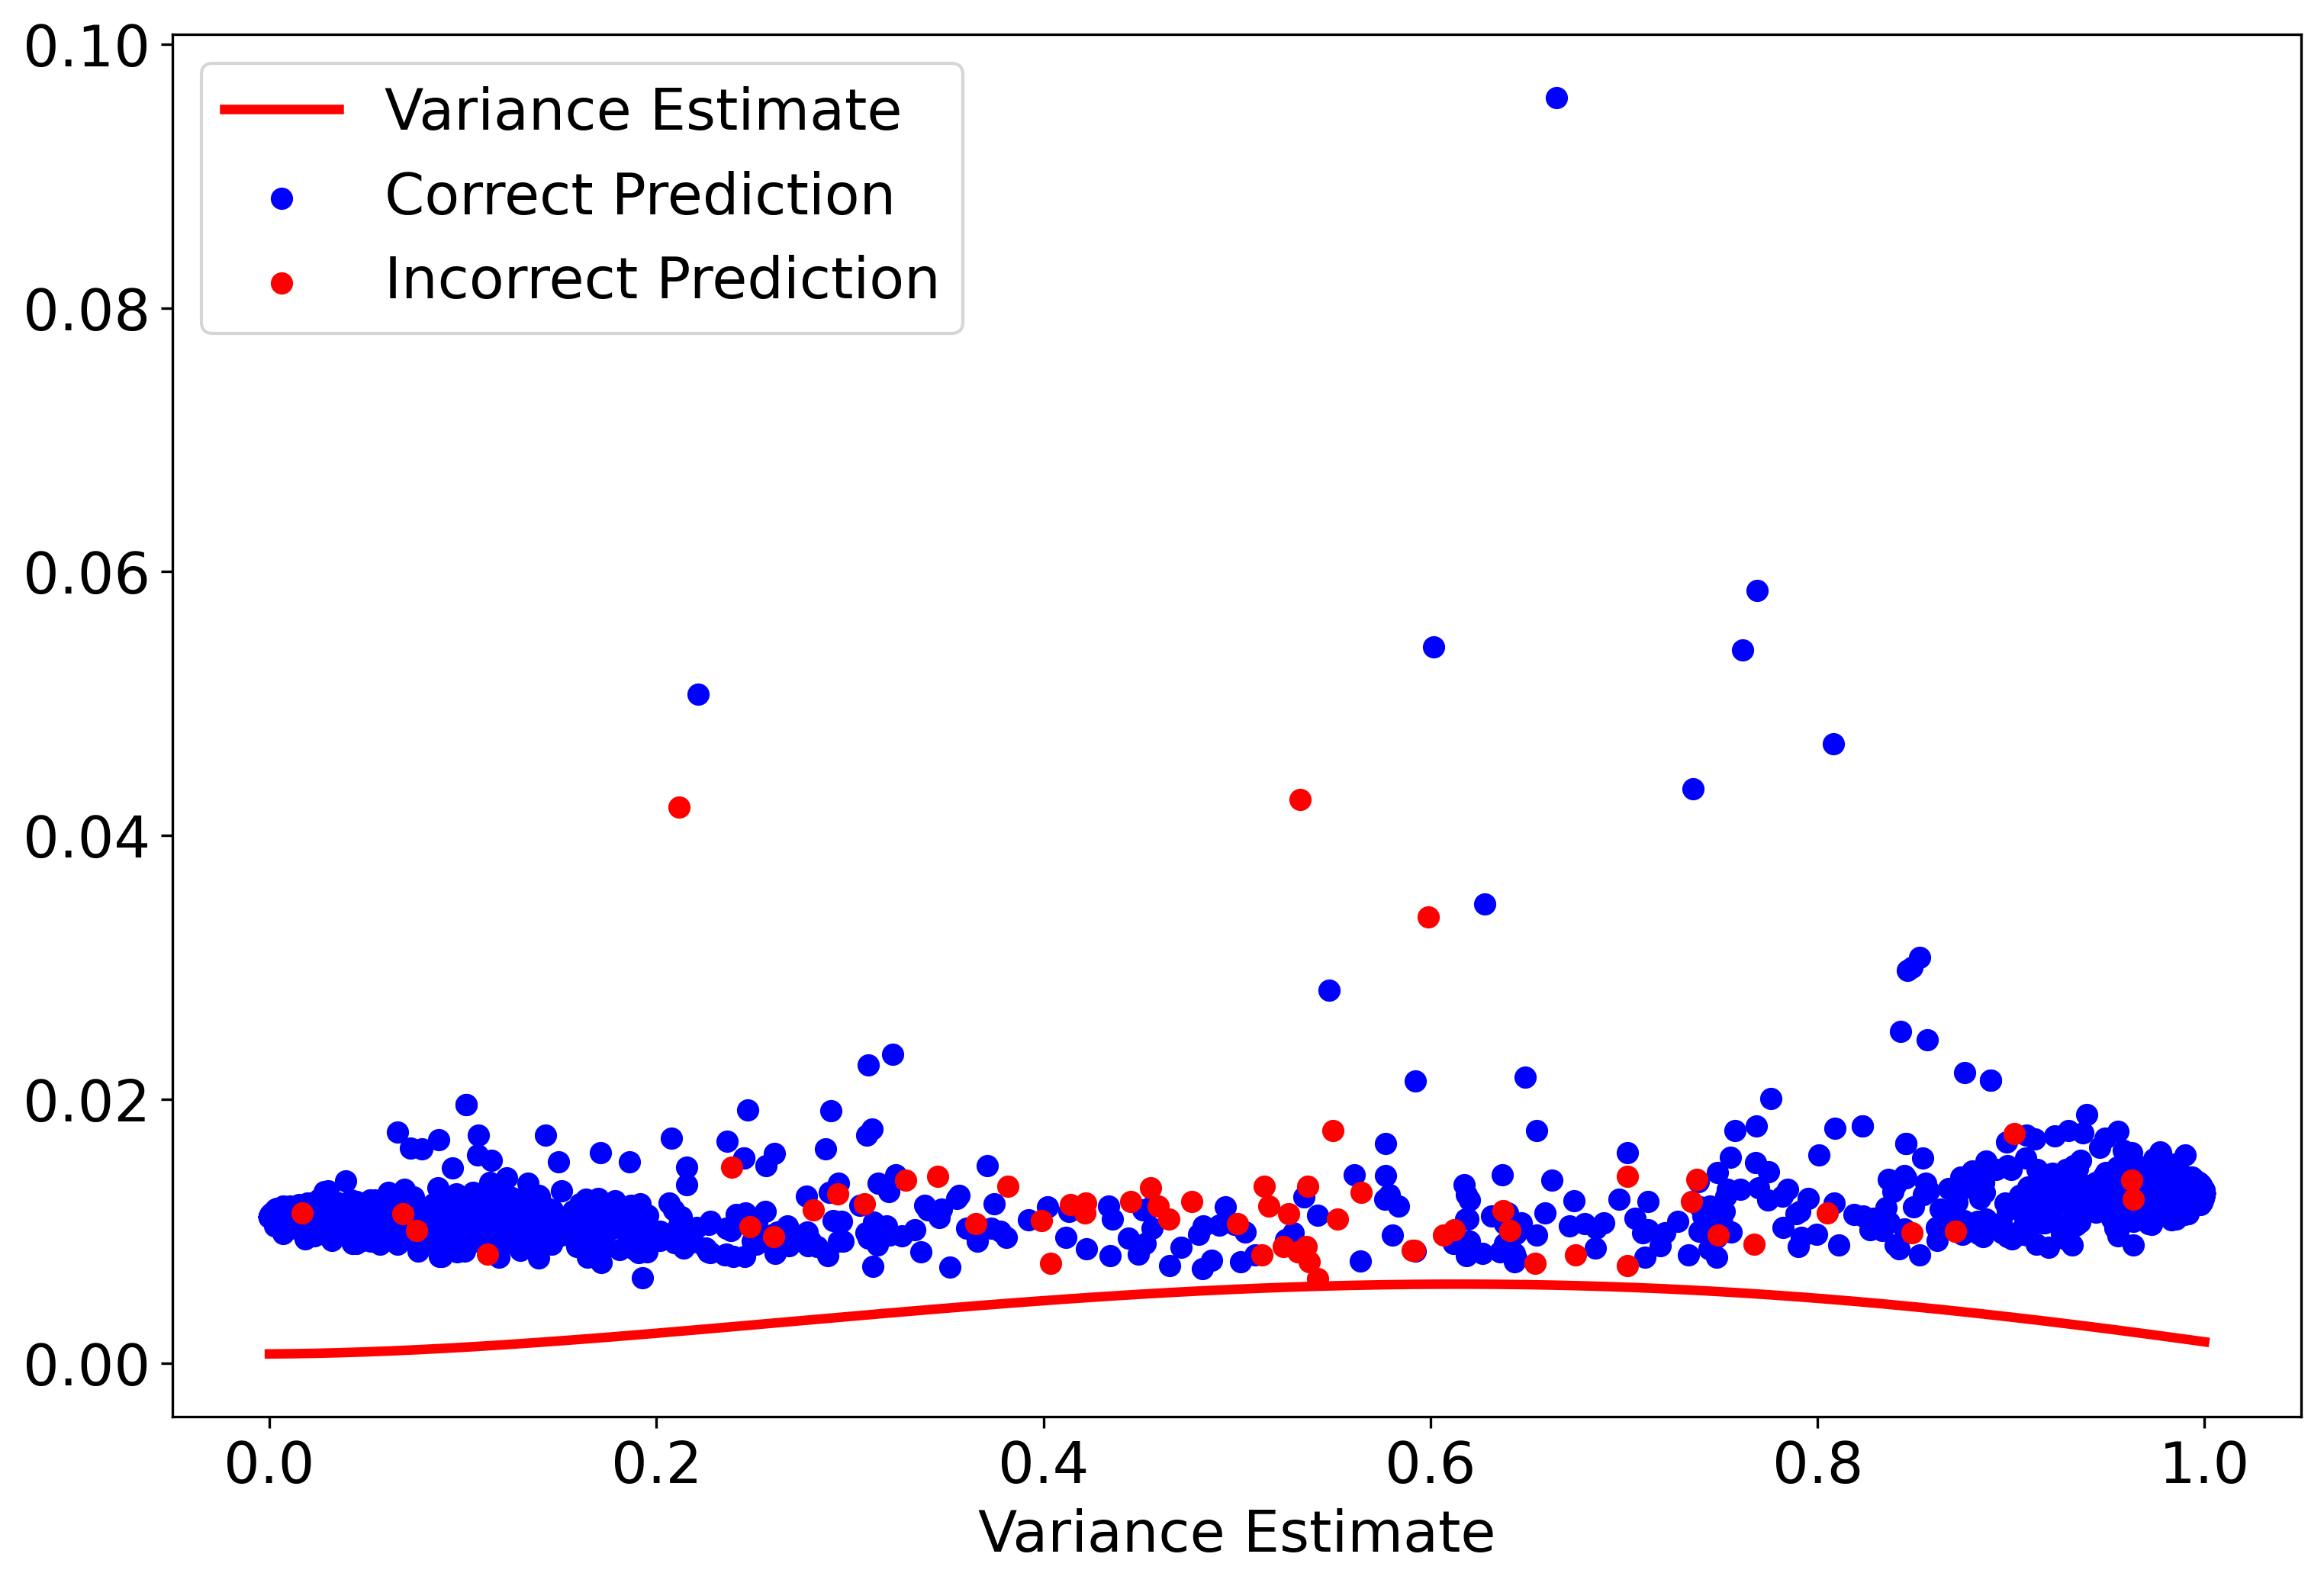

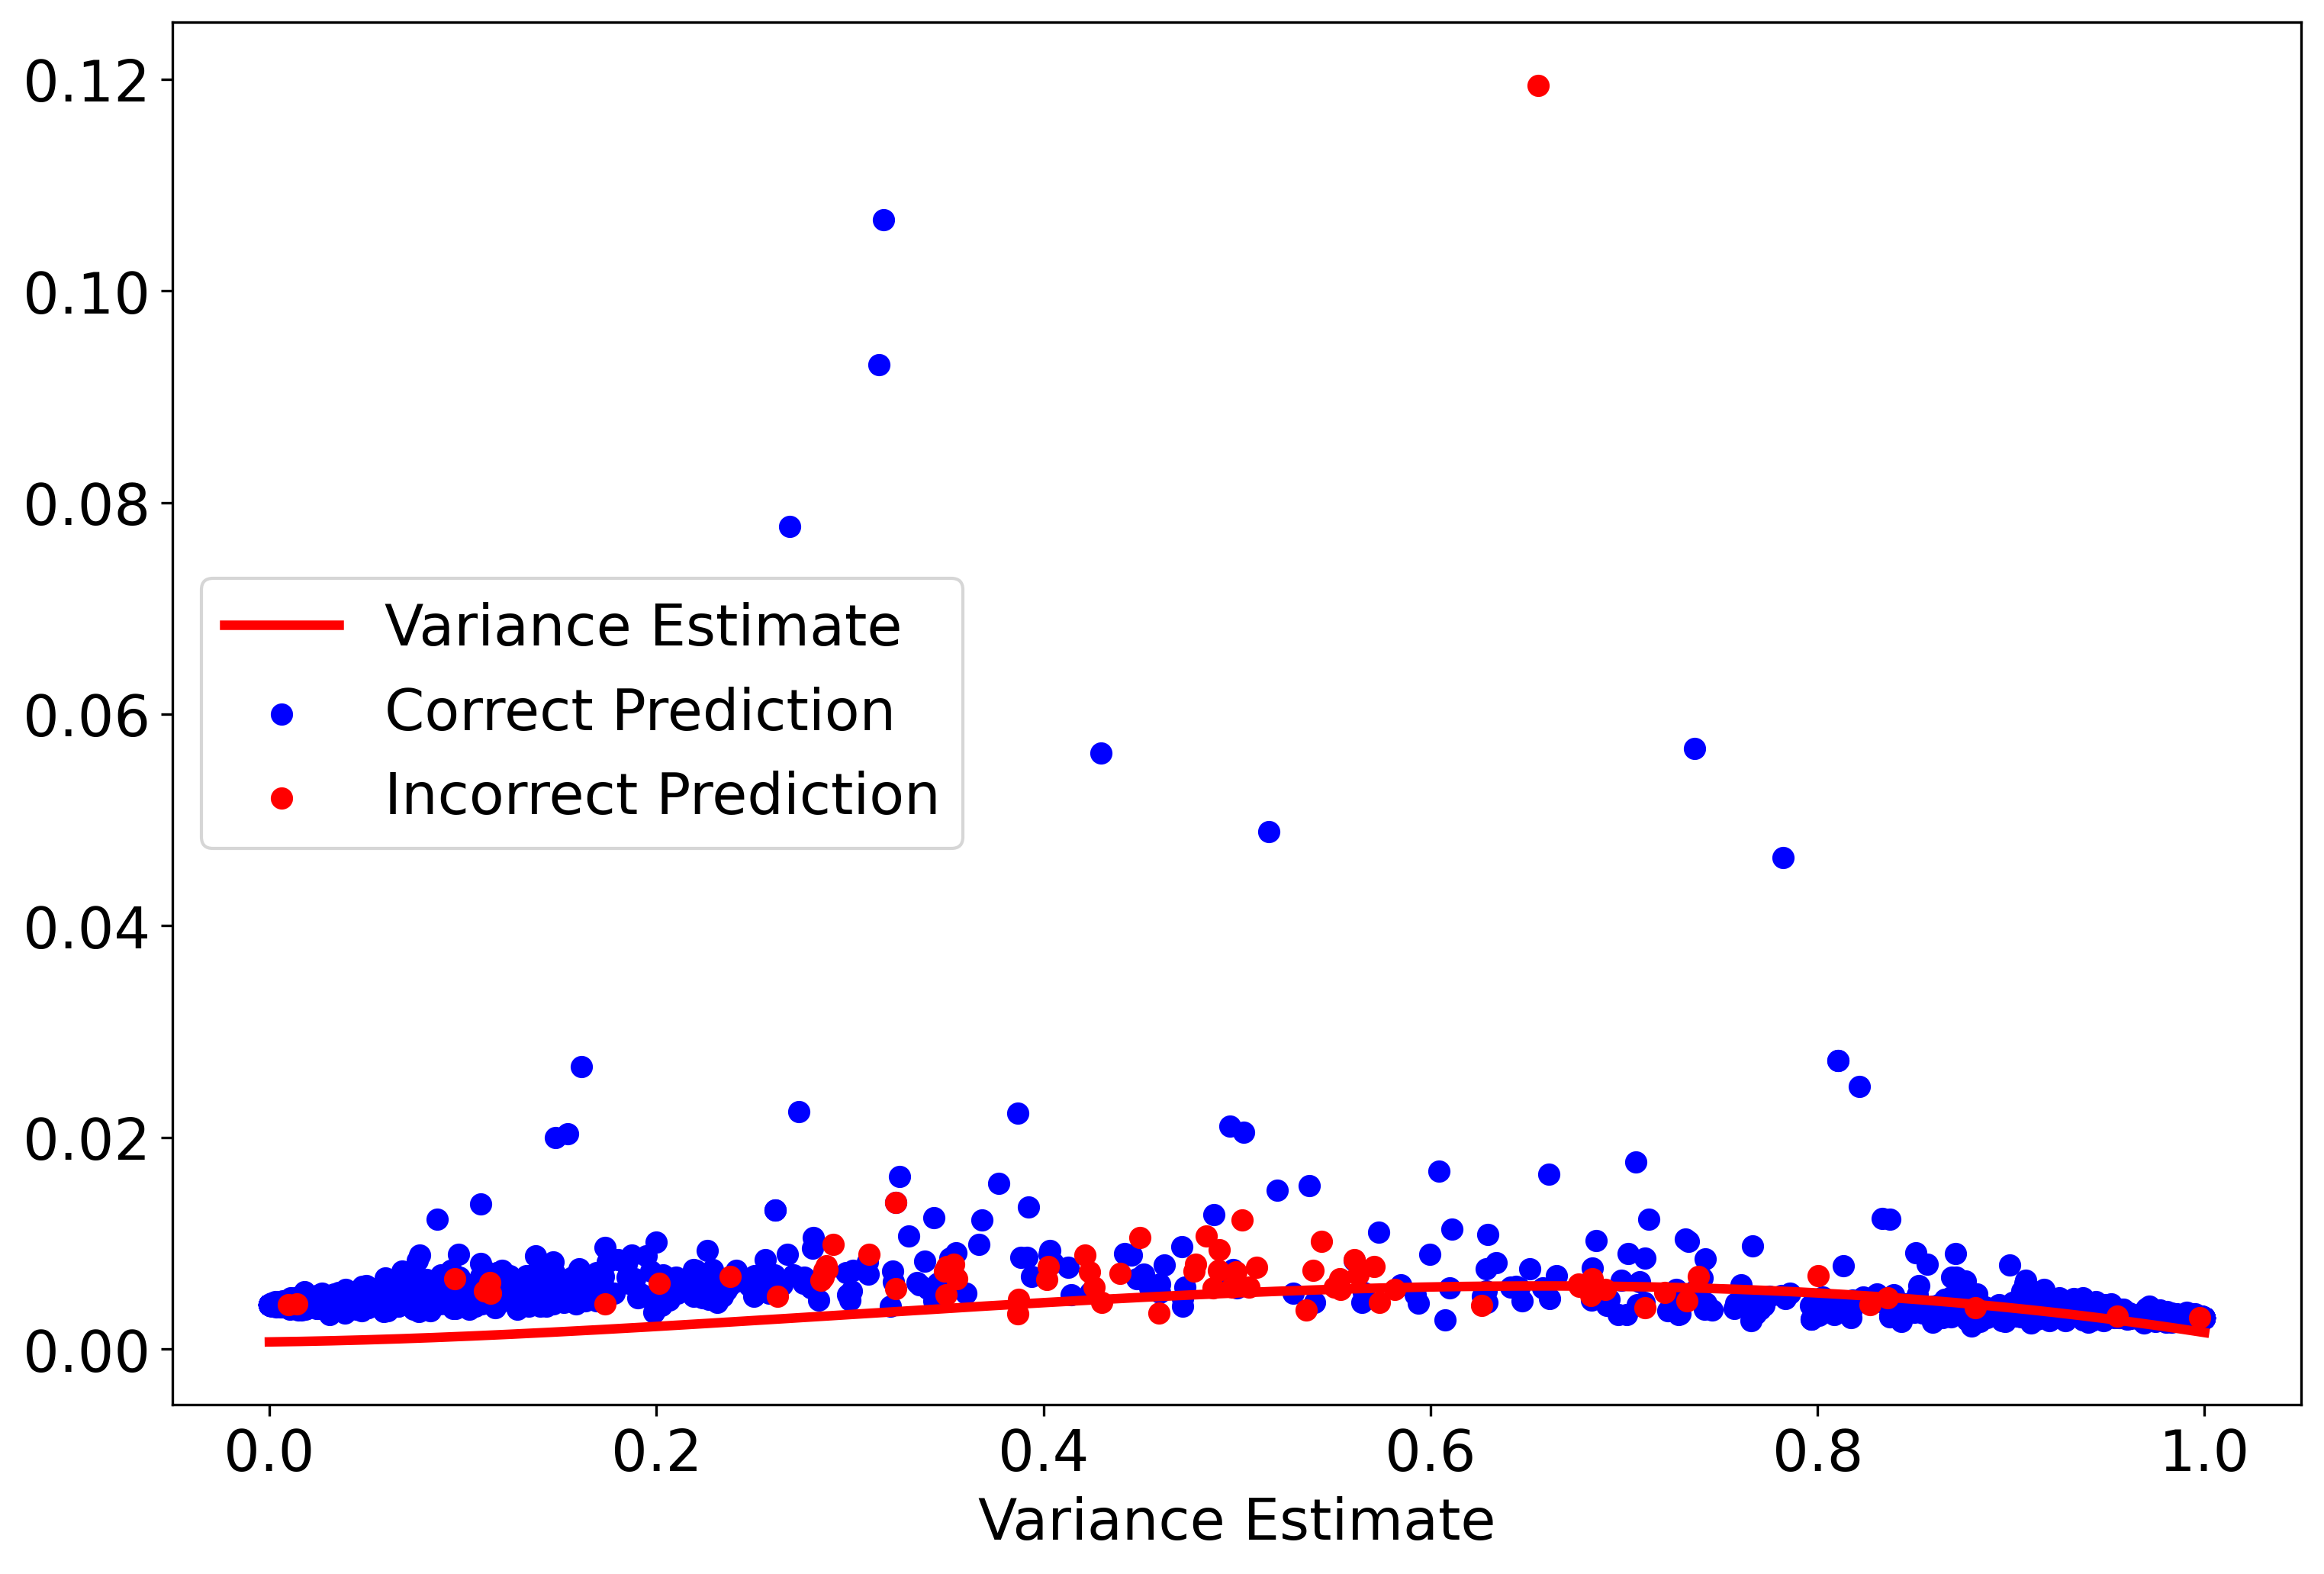

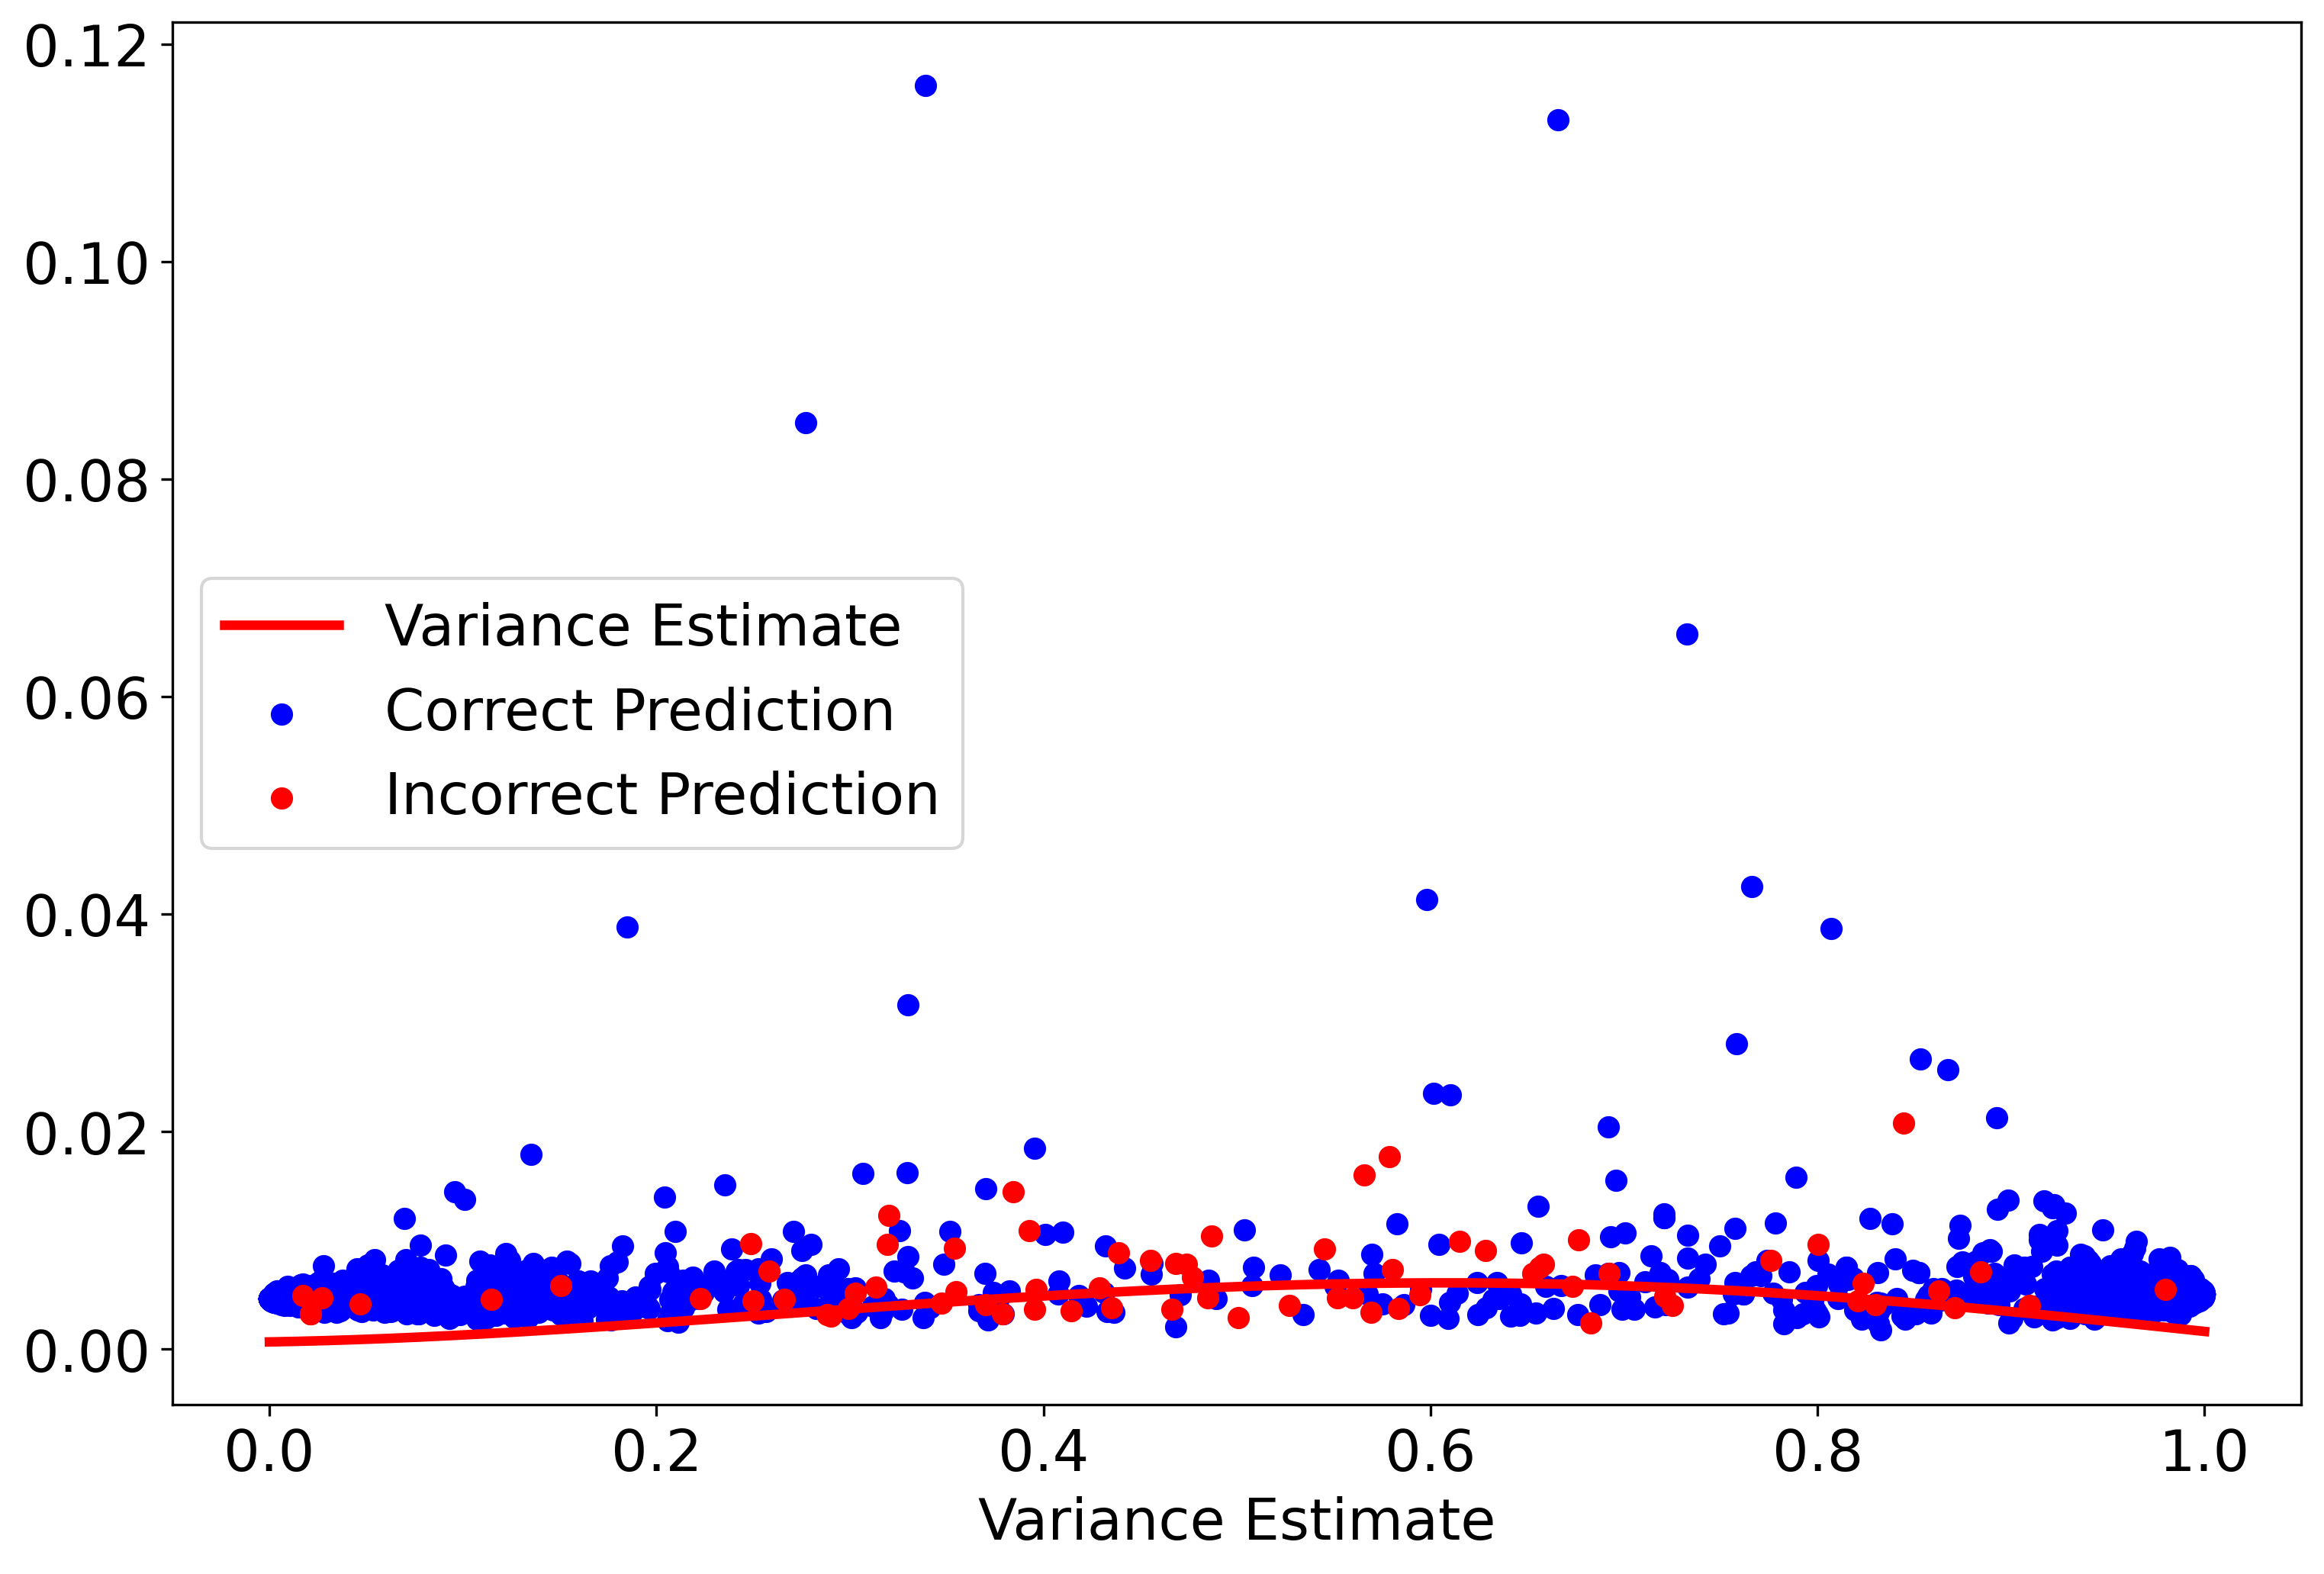

In [48]:
for i, max_feature in enumerate(max_features): 
    fig, axes = plt.subplots(figsize = (12, 8), nrows=1, ncols=1, dpi = 300)
    test_prob_correct, test_prob_error, V_IJ_correct, V_IJ_error, V_IJC_correct, V_IJC_error = collection[i][0]
    axes.scatter(test_prob_correct, V_IJC_correct, color = 'b', label = 'Correct Prediction')
    axes.scatter(test_prob_error, V_IJC_error, color = 'r', label = 'Incorrect Prediction')
    indice = np.argsort(np.concatenate([test_prob_correct, test_prob_error]))
    test_prob = np.concatenate([test_prob_correct, test_prob_error])[indice]
    V_IJC = np.concatenate([V_IJC_correct, V_IJC_error])[indice]
    spl = scipy.interpolate.UnivariateSpline(test_prob, V_IJ, k =5)
    xs = np.linspace(0, 1, 1000)
    axes.plot(xs, spl(xs), color = 'red', linewidth = 3, label = 'Variance Estimate')
    plt.xlabel('Prediction')
    plt.xlabel('Variance Estimate')
    plt.legend()
    plt.savefig('../figures/AC_Real' + str(i) + '.pdf', dpi = 300)
plt.show()